# Quantitative Trading Strategies Using Python
## Technical Analysis, Statistical Testing,and Machine Learning
—
### Peng Liu

#######################################################################################################################

## CHAPTER 5
## Trend-Following Strategy

### Analyzing Stock Prices Using Log Returns

##### Downloading Google’s stock price

In [ ]:
!pip install botorch
!pip install -U statsmodels
!pip install ta
!pip install yfinance
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.fit import fit_gpytorch_mll
from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from itertools import combinations
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import requests
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import ta
import torch
import torch.nn as nn
import yfinance as yf

In [ ]:
symbol = 'GOOG'
df = yf.download(symbol, start="2023-01-01", end="2023-01-08")
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,89.830002,91.550003,89.019997,89.699997,89.598038,20738500
2023-01-04,91.010002,91.239998,87.800003,88.709999,88.609169,27046500
2023-01-05,88.070000,88.209999,86.559998,86.769997,86.671371,23136100
2023-01-06,87.360001,88.470001,85.570000,88.160004,88.059799,26612600


##### Calculating the single-period percentage returns

In [ ]:
# single-period percentage returns
returns = df.Close.pct_change()
returns

Date
2023-01-03         NaN
2023-01-04   -0.011037
2023-01-05   -0.021869
2023-01-06    0.016019
Name: Close, dtype: float64

##### Calculating the terminal return using the original approach by definition

In [ ]:
# terminal return
terminal_return = df.Close[-1]/df.Close[0] - 1
terminal_return

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/518881421.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



-0.01716826464354737

##### Calculating the same cumulative terminal return by compounding 1+R formatted returns

In [ ]:
# cumulative returns
cum_returns = (1+returns).cumprod() - 1
cum_returns

Date
2023-01-03         NaN
2023-01-04   -0.011037
2023-01-05   -0.032664
2023-01-06   -0.017168
Name: Close, dtype: float64

In [ ]:
# check equality on terminal return
cum_returns.values[-1] == terminal_return

True

##### Calculating the log returns

In [ ]:
# log returns (1+R format)
log_returns = np.log(1+returns)
log_returns

Date
2023-01-03         NaN
2023-01-04   -0.011098
2023-01-05   -0.022112
2023-01-06    0.015892
Name: Close, dtype: float64

##### Calculating the cumulative returns using log returns

In [ ]:
# get cumulative returns using log returns
cum_return2 = np.exp(log_returns.cumsum()) - 1
cum_return2

Date
2023-01-03         NaN
2023-01-04   -0.011037
2023-01-05   -0.032664
2023-01-06   -0.017168
Name: Close, dtype: float64

In [ ]:
# check equality on terminal return
cum_return2.values[-1] == terminal_return

True

### Delving into Simple Moving Averages

##### Downloading Apple’s stock price data

In [ ]:
symbol = 'AAPL'
df = yf.download(symbol, start="2024-01-01")
df.index = pd.to_datetime(df.index)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,139.600006,140.615005,137.740005,139.559998,139.401367,20071900
2024-01-03,138.600006,141.089996,138.429993,140.360001,140.200455,18974300
2024-01-04,139.850006,140.634995,138.009995,138.039993,137.883087,18253300
2024-01-05,138.352005,138.809998,136.850006,137.389999,137.233841,15433200
2024-01-08,138.000000,140.639999,137.880005,140.529999,140.370270,17645300


##### Plotting the daily adjusted closing price

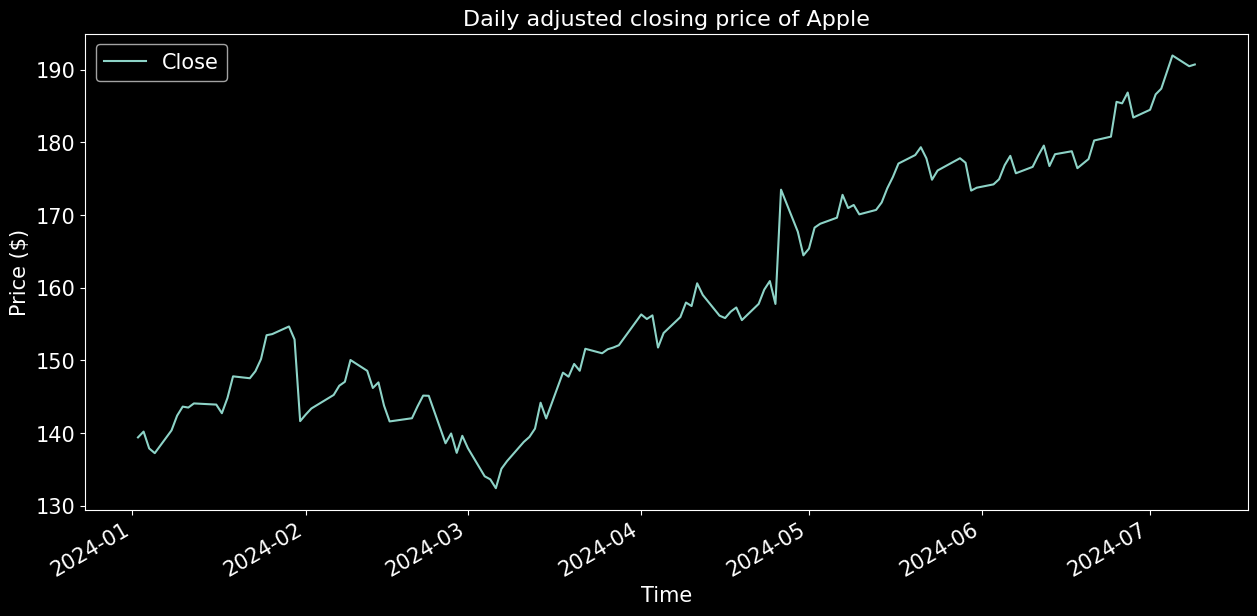

In [ ]:
# plot the adj closing price
plt.figure(figsize=(15, 7))
df['Adj Close'].plot()
# set labels and sizes of the title and axis
plt.title('Daily adjusted closing price of Apple', fontsize=16)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Price ($)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})
# show the plot
plt.show()

##### Creating simple moving averages

In [ ]:
window = 3
SMA1 = "SMA-"+str(window)
df[SMA1] = df['Adj Close'].rolling(window).mean()
colnames = ["Adj Close",SMA1]
df2 = df[colnames]
df2.head()

,Adj Close,SMA-3
Date,,
2024-01-02,139.401367,NaN
2024-01-03,140.200455,NaN
2024-01-04,137.883087,139.161636
2024-01-05,137.233841,138.439128
2024-01-08,140.370270,138.495733


In [ ]:
df['New_SMA'] = df['Adj Close'].rolling(window, min_periods=1).mean()
df[colnames + ['New_SMA']].head()

,Adj Close,SMA-3,New_SMA
Date,,,
2024-01-02,139.401367,NaN,139.401367
2024-01-03,140.200455,NaN,139.800911
2024-01-04,137.883087,139.161636,139.161636
2024-01-05,137.233841,138.439128,138.439128
2024-01-08,140.370270,138.495733,138.495733


##### Plotting the closing price and its SMA

Text(0, 0.5, 'Price')

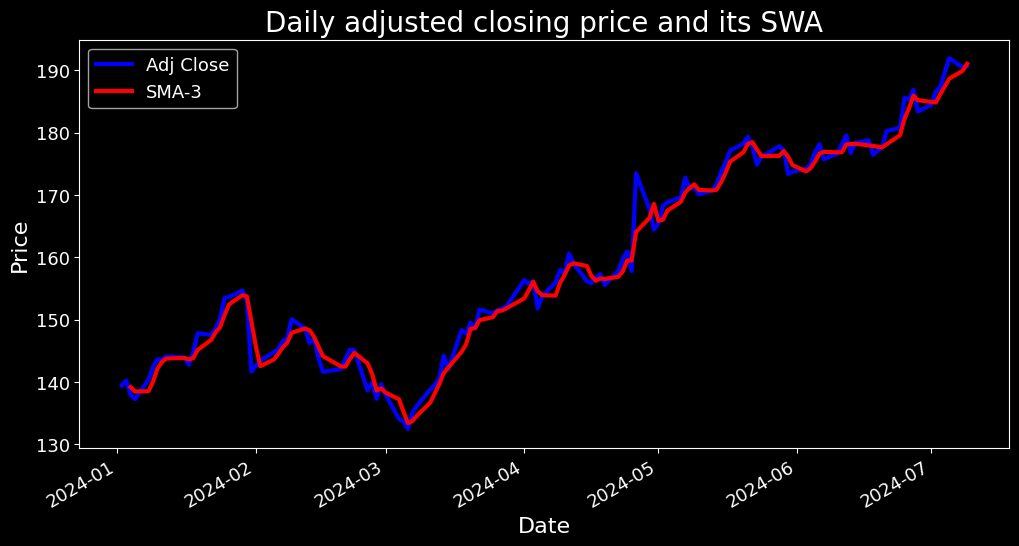

In [ ]:
# colors for the line plot
colors = ['blue', 'red']
# line plot for original price and SMA
df2.plot(color=colors, linewidth=3, figsize=(12,6))
# modify ticks size
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(labels = colnames, fontsize=13)
# title and labels
plt.title('Daily adjusted closing price and its SWA', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)

##### Creating 20-period SMA

In [ ]:
window = 20
SMA2 = "SMA-"+str(window)
df2["SMA-"+SMA2] = df2['Adj Close'].rolling(window).mean()
colnames = ["Adj Close",SMA1,SMA2]

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/3026950467.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### Plotting the closing price and two SMAs

Text(0, 0.5, 'Price')

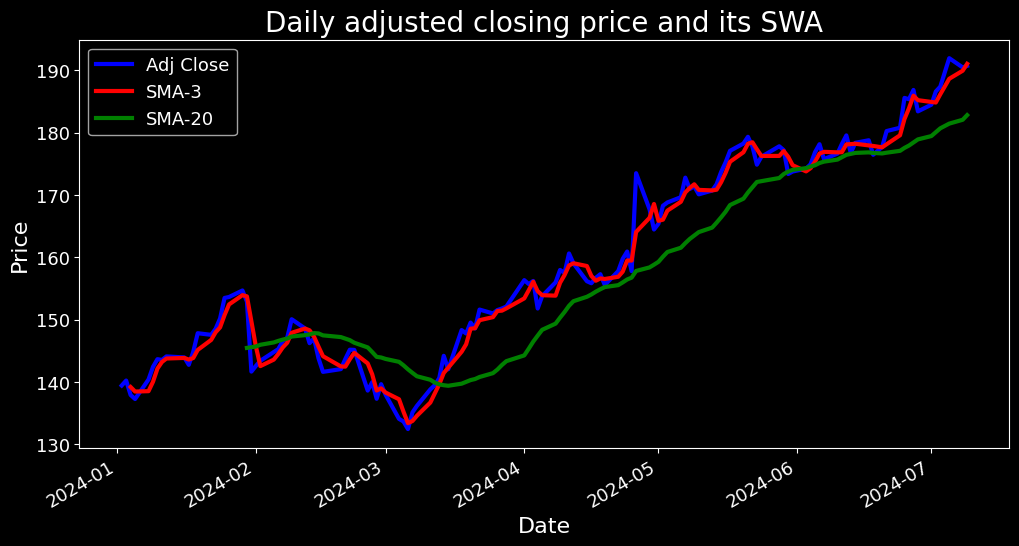

In [ ]:
# colors for the line plot
colors = ['blue', 'red', 'green']
# line plot for original price and SMA
df2.plot(color=colors, linewidth=3, figsize=(12,6))
# modify ticks size
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(labels = colnames, fontsize=13)
# title and labels
plt.title('Daily adjusted closing price and its SWA', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)

### Delving into Exponential Moving Averages

##### Creating EMA series

In [ ]:
alpha = 0.1
df2['EWM_'+str(alpha)] = df2['Adj Close'].ewm(alpha=alpha, adjust=False).mean()
df2.head()

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/992842075.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Adj Close,SMA-3,SMA-SMA-20,EWM_0.1
Date,,,,
2024-01-02,139.401367,NaN,NaN,139.401367
2024-01-03,140.200455,NaN,NaN,139.481276
2024-01-04,137.883087,139.161636,NaN,139.321457
2024-01-05,137.233841,138.439128,NaN,139.112695
2024-01-08,140.370270,138.495733,NaN,139.238453


In [ ]:
alpha=0.1
alpha*df2['Adj Close'][1] + (1-alpha)*df2['Adj Close'][0]

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/1163581393.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



139.4812759399414

In [ ]:
alpha = 0.5
df2['EWM_'+str(alpha)]= df2['Adj Close'].ewm(alpha=alpha,adjust=False).mean()
df2.head()

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/1479772798.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Adj Close,SMA-3,SMA-SMA-20,EWM_0.1,EWM_0.5
Date,,,,,
2024-01-02,139.401367,NaN,NaN,139.401367,139.401367
2024-01-03,140.200455,NaN,NaN,139.481276,139.800911
2024-01-04,137.883087,139.161636,NaN,139.321457,138.841999
2024-01-05,137.233841,138.439128,NaN,139.112695,138.037920
2024-01-08,140.370270,138.495733,NaN,139.238453,139.204095


##### Plotting all moving averages together

Text(0, 0.5, 'Price')

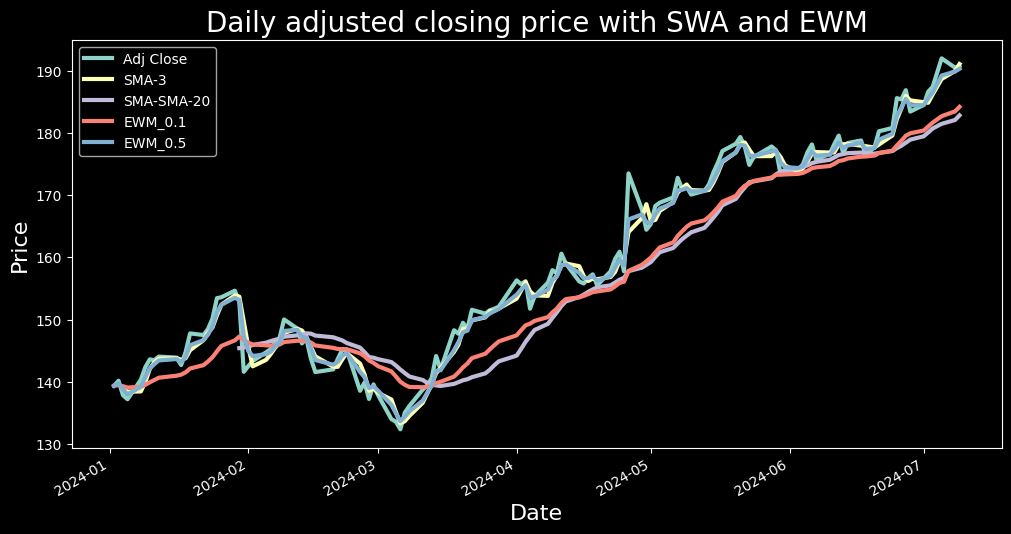

In [ ]:
df2.plot(linewidth=3, figsize=(12,6))
plt.title('Daily adjusted closing price with SWA and EWM', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)

### Implementing the Trend-Following Strategy

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130 entries, 2024-01-02 to 2024-07-09
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj Close   130 non-null    float64
 1   SMA-3       128 non-null    float64
 2   SMA-SMA-20  111 non-null    float64
 3   EWM_0.1     130 non-null    float64
 4   EWM_0.5     130 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [ ]:
# Shift to the future by one day so that everyday uses the information up to
# yesterday to make a trading decision for tmr
df2['SMA-3'] = df2['SMA-3'].shift(1)
df2['SMA-20'] = df2['SMA-SMA-20'].shift(1)

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/3641980385.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/3641980385.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### Creating and identifying buy and sell signals

In [ ]:
# identify buy signal
df2['signal'] = np.where(df2['SMA-3'] > df2['SMA-20'], 1, 0)
# identify sell signal
df2['signal'] = np.where(df2['SMA-3'] < df2['SMA-20'], -1, df2['signal'])
df2.dropna(inplace=True)

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/2287473548.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/2287473548.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/2287473548.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [ ]:
df2['signal'].value_counts()

signal
 1    84
-1    26
Name: count, dtype: int64

In [ ]:
df2

,Adj Close,SMA-3,SMA-SMA-20,EWM_0.1,EWM_0.5,SMA-20,signal
Date,,,,,,,
2024-01-31,141.638824,153.718409,145.553368,146.737116,147.421251,145.441495,1
2024-02-01,142.547791,149.726288,145.670734,146.318183,144.984521,145.553368,1
2024-02-02,143.376831,145.687551,145.945422,146.024048,144.180676,145.670734,1
2024-02-05,144.765259,142.521149,146.321992,145.898169,144.472967,145.945422,-1
2024-02-06,145.244720,143.563293,146.565715,145.832824,144.858844,146.321992,-1
...,...,...,...,...,...,...,...
2024-07-02,186.610001,184.923335,180.075348,181.009768,185.536419,179.455935,1
2024-07-03,187.389999,184.840001,180.698301,181.647791,186.463209,180.075348,1
2024-07-05,191.960007,186.163335,181.452864,182.679013,189.211608,180.698301,1


##### Calculating the log return of the trend-following strategy

In [ ]:
df2['log_return_buy_n_hold'] = np.log(df2['Adj Close']).diff()

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/1391299510.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df2

,Adj Close,SMA-3,SMA-SMA-20,EWM_0.1,EWM_0.5,SMA-20,signal,log_return_buy_n_hold
Date,,,,,,,,
2024-01-31,141.638824,153.718409,145.553368,146.737116,147.421251,145.441495,1,NaN
2024-02-01,142.547791,149.726288,145.670734,146.318183,144.984521,145.553368,1,0.006397
2024-02-02,143.376831,145.687551,145.945422,146.024048,144.180676,145.670734,1,0.005799
2024-02-05,144.765259,142.521149,146.321992,145.898169,144.472967,145.945422,-1,0.009637
2024-02-06,145.244720,143.563293,146.565715,145.832824,144.858844,146.321992,-1,0.003307
...,...,...,...,...,...,...,...,...
2024-07-02,186.610001,184.923335,180.075348,181.009768,185.536419,179.455935,1,0.011426
2024-07-03,187.389999,184.840001,180.698301,181.647791,186.463209,180.075348,1,0.004171
2024-07-05,191.960007,186.163335,181.452864,182.679013,189.211608,180.698301,1,0.024095


In [ ]:
df2['log_return_trend_follow'] = df2['signal'] * df2['log_return_buy_n_hold']

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/1821275900.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df2

,Adj Close,SMA-3,SMA-SMA-20,EWM_0.1,EWM_0.5,SMA-20,signal,log_return_buy_n_hold,log_return_trend_follow
Date,,,,,,,,,
2024-01-31,141.638824,153.718409,145.553368,146.737116,147.421251,145.441495,1,NaN,NaN
2024-02-01,142.547791,149.726288,145.670734,146.318183,144.984521,145.553368,1,0.006397,0.006397
2024-02-02,143.376831,145.687551,145.945422,146.024048,144.180676,145.670734,1,0.005799,0.005799
2024-02-05,144.765259,142.521149,146.321992,145.898169,144.472967,145.945422,-1,0.009637,-0.009637
2024-02-06,145.244720,143.563293,146.565715,145.832824,144.858844,146.321992,-1,0.003307,-0.003307
...,...,...,...,...,...,...,...,...,...
2024-07-02,186.610001,184.923335,180.075348,181.009768,185.536419,179.455935,1,0.011426,0.011426
2024-07-03,187.389999,184.840001,180.698301,181.647791,186.463209,180.075348,1,0.004171,0.004171
2024-07-05,191.960007,186.163335,181.452864,182.679013,189.211608,180.698301,1,0.024095,0.024095


In [ ]:
df2['action'] = df2.signal.diff()

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/3224628441.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df2

,Adj Close,SMA-3,SMA-SMA-20,EWM_0.1,EWM_0.5,SMA-20,signal,log_return_buy_n_hold,log_return_trend_follow,action
Date,,,,,,,,,,
2024-01-31,141.638824,153.718409,145.553368,146.737116,147.421251,145.441495,1,NaN,NaN,NaN
2024-02-01,142.547791,149.726288,145.670734,146.318183,144.984521,145.553368,1,0.006397,0.006397,0.0
2024-02-02,143.376831,145.687551,145.945422,146.024048,144.180676,145.670734,1,0.005799,0.005799,0.0
2024-02-05,144.765259,142.521149,146.321992,145.898169,144.472967,145.945422,-1,0.009637,-0.009637,-2.0
2024-02-06,145.244720,143.563293,146.565715,145.832824,144.858844,146.321992,-1,0.003307,-0.003307,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-07-02,186.610001,184.923335,180.075348,181.009768,185.536419,179.455935,1,0.011426,0.011426,0.0
2024-07-03,187.389999,184.840001,180.698301,181.647791,186.463209,180.075348,1,0.004171,0.004171,0.0
2024-07-05,191.960007,186.163335,181.452864,182.679013,189.211608,180.698301,1,0.024095,0.024095,0.0


In [ ]:
df2['action'].value_counts()

action
 0.0    103
-2.0      3
 2.0      3
Name: count, dtype: int64

##### Visualizing trading actions

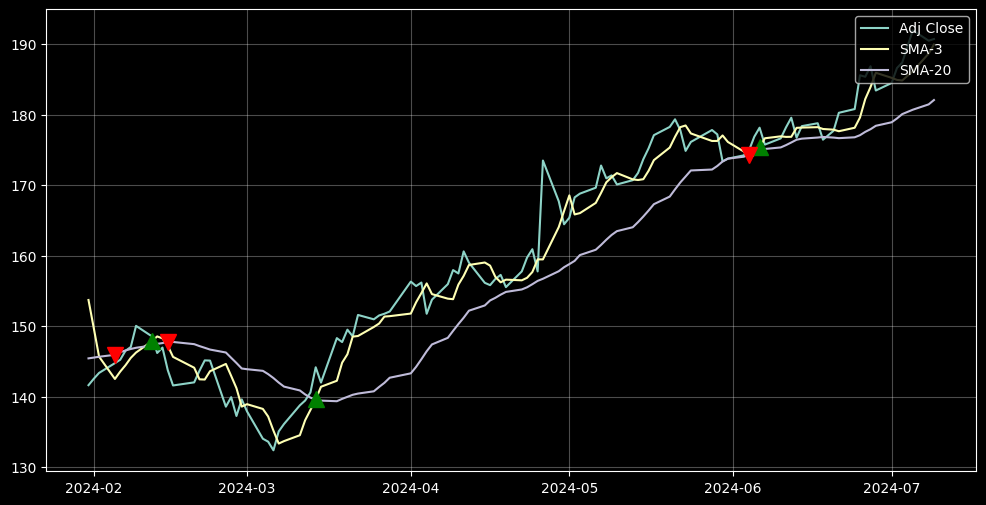

In [ ]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(df2['Adj Close'], label = 'Adj Close')
plt.plot(df2['SMA-3'], label = 'SMA-3')
plt.plot(df2['SMA-20'], label = 'SMA-20')
plt.plot(df2.loc[df2.action == 2].index, df2['SMA-3'][df2.action == 2], '^', color = 'g', markersize = 12)
plt.plot(df2[df2.action == -2].index, df2['SMA-20'][df2.action == -2], 'v', color = 'r', markersize = 12)
plt.legend(loc=1)

##### Visualizing cumulative returns

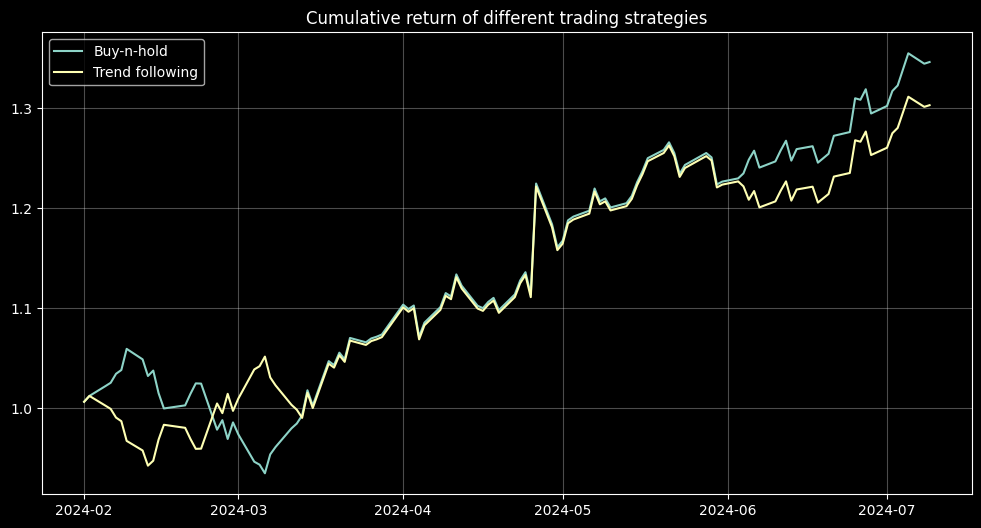

In [ ]:
plt.plot(np.exp(df2['log_return_buy_n_hold']).cumprod(),label='Buy-n-hold')
plt.plot(np.exp(df2['log_return_trend_follow']).cumprod(), label='Trend following')
plt.legend(loc=2)
plt.title("Cumulative return of different trading strategies")
plt.grid(True, alpha=.3)

In [ ]:
# terminal return of buy-n-hold
np.exp(df2['log_return_buy_n_hold']).cumprod()[-1] -1

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/3169240478.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



0.3465234687165297

In [ ]:
# terminal return of trend following
np.exp(df2['log_return_trend_follow']).cumprod()[-1] -1

/var/folders/nr/kmlljdx179d88t_l2f30j48h0000gr/T/ipykernel_37912/902883811.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



0.3033105605517079

##############################################################################################################